In [1]:
import warnings
warnings.filterwarnings('ignore')
import classyRF_final as classyRF
import numpy as np
import matplotlib.pyplot as plt

In [2]:
EOS = ["APR4_EPP", "BHF_BBB2", "H4", "HQC18", "KDE0V", "KDE0V1", "MPA1", "MS1_PP", "MS1B_PP", "RS", "SK255", "SK272", "SKI2", "SKI3", "SKI4", "SKI5", "SKI6", "SKMP", "SKOP", "SLy", "SLY2", "SLY9", "SLY230A"]
BayesFactor=[1.526, 1.555, 0.056, 1.422, 1.177, 1.283, 0.276, 0.001, 0.009, 0.176, 0.179, 0.159, 0.108, 0.107, 0.33, 0.025, 0.288, 0.29, 0.618, 1.0, 1.028, 0.37, 0.932]
EOSTest = ["APR4_EPP", "BHF_BBB2"]
EOScolor = ['BHF_BBB2', 'SLy', 'MS1B_PP']
color_v = ['orange', 'green', 'blue']

i_m1r=1; i_m2r=2; i_x1r=3; i_x2r=4; i_snr=8;
recovered=[i_m1r, i_m2r, i_x1r, i_x2r, i_snr]

In [6]:
pathData = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\allEOS\\"
pathClassy = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\"
pathForest = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\Sushant_forests_2\\"

In [7]:
EOSdic = {}
count = 0
for eos in EOS:
    new_dic = {}
    RF = classyRF.ClassificationRF()
    RF.loadPickle(pathForest+eos)
    RF.load_test_dataset(pathData+eos+'\\EMB\\', 'test_EMB_ID_LABEL_'+eos+'_s300_f0d7.csv')
    new_dic['label_REM'] = RF.labels_test
    aux = RF.labels_test
    RF.load_test_dataset(pathData+eos+'\\NS\\', 'test_NS_ID_LABEL_'+eos+'_s300_f0d7.csv')
    new_dic['label_NS'] = RF.labels_test
    RF.labels_test = RF.labels_test + aux
    RF.subset_test(recovered)
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    EOSdic[eos] = new_dic
    count = count + 1 

# Compute Bayesian using O2 test set

$$ P(HasNS|X)= \dfrac{\text{events with NS giving X}}{\text{events giving X}}$$

In [8]:
#X is trees say 1 + trees say 2

### Compute what the forest say for an event, and save f1+f2, f2

In [28]:
N = len(EOSdic['APR4_EPP']['forest'].data_test)
eos = 'APR4_EPP'
EOSdic[eos]['f1+f2'] = np.zeros(N)
EOSdic[eos]['f2'] = np.zeros(N)
for i in range(0, 50):
    predictions_trees= EOSdic[eos]['forest'].model.estimators_[i].predict(EOSdic[eos]['forest'].data_test)
    for k in range(0, N):
        if predictions_trees[k] == 1:
            EOSdic[eos]['f1+f2'][k] = EOSdic[eos]['f1+f2'][k] + 1
        if predictions_trees[k] == 2:
            EOSdic[eos]['f1+f2'][k] = EOSdic[eos]['f1+f2'][k] + 1
            EOSdic[eos]['f2'][k] = EOSdic[eos]['f2'][k] + 1    
    

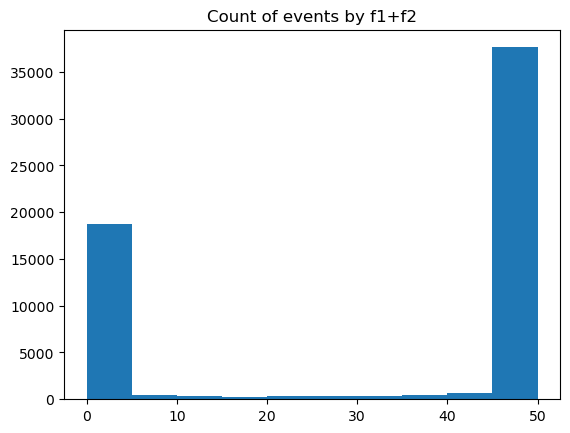

In [31]:
plt.title('Count of events by f1+f2')
_=plt.hist(EOSdic[eos]['f1+f2'])

The histogram shows that we barely have any information when there is an intermediate number of trees in f1+f2. This is bad for etrapolating a probability

## Compute ROC curves of O2 test set Bayesian Probabilities

In [47]:
index_NS = np.where(EOSdic[eos]['label_NS']==1)[0]

In [58]:
len(index_NS)

38972

In [51]:
print(np.count_nonzero(EOSdic[eos]['f1+f2']==2))

341


In [59]:
np.count_nonzero(EOSdic[eos]['f1+f2'][index_NS]==2)

9

In [ ]:
 # Events giving X: np.count_nonzero(EOSdic[eos]['f1+f2']==X)
 # Events with NS giving X: np.count_nonzero(EOSdic[eos]['f1+f2'][index_NS]==X)

In [60]:
EOSdic[eos]['Bayesian'] = np.zeros(51)
for i in range(0,51):
    EOSdic[eos]['Bayesian'][i]=np.count_nonzero(EOSdic[eos]['f1+f2'][index_NS]==i)/np.count_nonzero(EOSdic[eos]['f1+f2']==i)

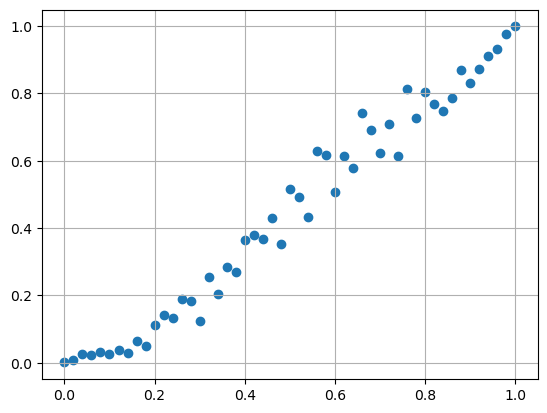

In [65]:
plt.scatter(np.linspace(0,1,51), EOSdic[eos]['Bayesian'])
plt.grid()

Analysis: from what numbers do we obtain this curve?

In [66]:
for i in range(0,51):
    print(np.count_nonzero(EOSdic[eos]['f1+f2'][index_NS]==i),"/",np.count_nonzero(EOSdic[eos]['f1+f2']==i))

16 / 17344
6 / 694
9 / 341
5 / 216
6 / 180
3 / 121
4 / 105
3 / 102
6 / 94
4 / 82
7 / 62
10 / 71
9 / 67
16 / 85
15 / 82
7 / 56
14 / 55
11 / 54
15 / 53
14 / 52
20 / 55
24 / 63
25 / 68
30 / 70
18 / 51
33 / 64
28 / 57
32 / 74
44 / 70
42 / 68
38 / 75
51 / 83
44 / 76
46 / 62
49 / 71
48 / 77
56 / 79
59 / 96
87 / 107
74 / 102
95 / 118
89 / 116
107 / 143
114 / 145
139 / 160
177 / 213
221 / 253
322 / 354
550 / 590
1567 / 1604
34563 / 34608


Conclusion: there are not enough events to construct a bayesian probability when the fraction of forests is far from the extremes. There are 50 different fractions to separate, the events are too distributed. For HasREM this is even more noticeable.

In KNN the events are distributed only in 8 different fractions (neighbours), so the probabilities are more fundamented, the curves are more reliable: the final application is more trustworthy => better ROC